In [1]:
import torch
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import DPMSolverMultistepScheduler
from transformers import Gemma2Model, GemmaTokenizerFast

model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

transformer = SanaTransformer2DModel.from_pretrained(model, subfolder="transformer", torch_dtype=dtype).to(device)
dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)
text_encoder = Gemma2Model.from_pretrained(model, subfolder="text_encoder", torch_dtype=dtype).to(device)
tokenizer = GemmaTokenizerFast.from_pretrained(model, subfolder="tokenizer", torch_dtype=dtype)
scheduler = DPMSolverMultistepScheduler.from_pretrained(model, subfolder="scheduler")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
def encode_prompt(prompt, tokenizer, text_encoder):
    # lower case prompt! took a long time to find that this is necessary: https://github.com/huggingface/diffusers/blob/e8aacda762e311505ba05ae340af23b149e37af3/src/diffusers/pipelines/sana/pipeline_sana.py#L433
    tokenizer.padding_side = "right"
    prompt = prompt.lower().strip()
    prompt_tok = tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=300, add_special_tokens=True).to(text_encoder.device)
    with torch.no_grad():
        prompt_encoded=text_encoder(**prompt_tok)
    return prompt_encoded.last_hidden_state, prompt_tok.attention_mask

prompt_encoded, prompt_atnmask = encode_prompt("a beautiful mountain landscape", tokenizer, text_encoder)
prompt_encoded.shape, prompt_atnmask.shape

(torch.Size([1, 300, 2304]), torch.Size([1, 300]))

In [3]:
import torchvision.transforms as T

# DC-AE scaling factor, see https://huggingface.co/Efficient-Large-Model/Sana_600M_1024px_diffusers/blob/main/vae/config.json
dcae_scalingf = 0.41407

def latent_to_PIL(latent, ae):
    with torch.no_grad():
        image_out = ae.decode(latent).sample.squeeze().to("cpu")    
    image_out = torch.clamp_(image_out, -1, 1)    # clamp, because output of is AE sometimes out of [-1;1] for some reason
    image_out = image_out * 0.5 + 0.5 # normalize to 0-1    
    return T.ToPILImage()(image_out.float())  

def PIL_to_latent(image, ae):
    transform = T.Compose([
        T.Resize(1024, antialias=True),
        # This will center crop from the resized image
        T.CenterCrop(1024),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        lambda x: x.to(dtype=torch.bfloat16)
    ])

    image_tensor = transform(image)[None].to(device)

    with torch.no_grad():
        latent = ae.encode(image_tensor)
    return latent.latent

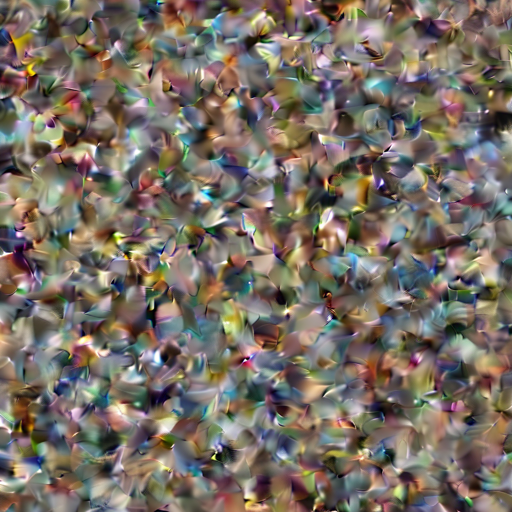

torch.Size([1, 32, 32, 32]) -3.84375 3.890625


In [4]:
latents=torch.randn(1, 32, 32, 32).to(dtype).to(device)

display(latent_to_PIL(latents / dcae_scalingf, dcae).resize((512,512)))
print(latents.shape, latents.min().item(), latents.max().item())

5it [00:03,  1.40it/s]


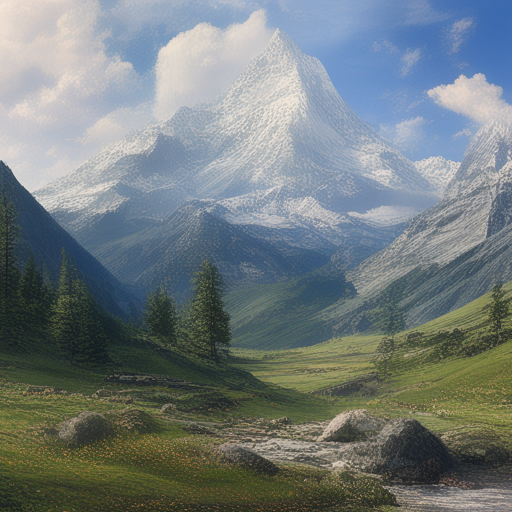

In [5]:
from tqdm import tqdm

prompt = "A beautiful mountain landscape, photorealistic"
steps = 5

prompt_encoded, prompt_atnmask = encode_prompt(prompt, tokenizer, text_encoder)
# latent size 32x32 ==(* resize factor=32 [dc-ae-f32c32])==> 1024x1024px 
latents = torch.randn(1, 32, 32, 32, generator = torch.manual_seed(32)).to(dtype).to(device)
scheduler.set_timesteps(steps)

for i,t in tqdm(enumerate(scheduler.timesteps)):
    t = t.expand(latents.shape[0]).to(latents.dtype).to(device)
    with torch.no_grad():
        noise_pred = transformer(latents, encoder_hidden_states=prompt_encoded, timestep=t, encoder_attention_mask=prompt_atnmask, return_dict=False)[0]
    latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]
    
latent_to_PIL(latents / dcae_scalingf, dcae).resize((512, 512))